# Comparison of thin plate spline and its Laplacian approximation in 2D

This notebook reproduces figures from the paper

In [2]:
using Laplacians, LinearAlgebra, SparseArrays, LaplaceInterpolation
using TestImages, Colors, FileIO, JLD, BenchmarkTools
using Plots, ThinPlateSplines

## Mandrill 2D Example

Here we load in the mandrill test image and discard roughly 75% of the data.

There are 129540 interior nodes, and 1534 boundary nodes.
We discard 76.2939453125 percent of the data.


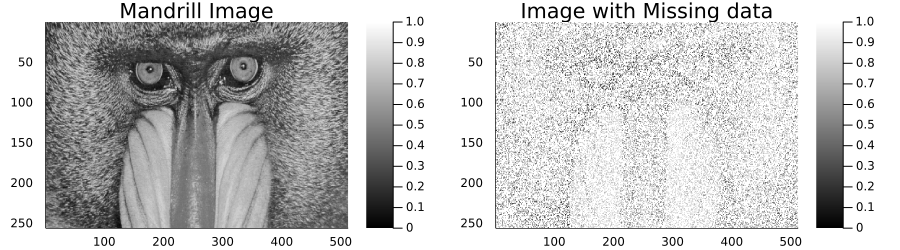

In [3]:
# Example from TestImages package
img = testimage("mandrill")

# Flatten the image to grayscale and select a subset of the image
imgg = Gray.(img)
rows, columns = (256, 512)
N = rows*columns

mat = convert(Array{Float64}, imgg)[1:rows,1:columns]

println("There are $((rows - 2) * (columns - 2)) interior nodes, and $(2 * rows + 2 * columns - 2) boundary nodes.")

No_of_nodes_discarded = 100000

println("We discard $(100.0 * No_of_nodes_discarded / N) percent of the data.")

discard = randperm(N)[1:No_of_nodes_discarded]

holeyimage1 = copy(mat)
holeyimage1[discard] .= 1

p1 = heatmap(mat, title = "Original Data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p2 = heatmap(holeyimage1, title = "Image with Missing data", yflip = true, 
              c = :bone, clims = (0.0, 1.0))

plot(p1, p2, layout = (1,2), size = (900, 250))

# Reconstruction using Matern and Laplace interpolations

In [4]:
restored_img_laplace = Matern2D_Grid(mat, 0.0, 1, discard)
restored_img_matern = Matern2D_Grid(mat, 0.0, 2, discard)

#=
A2D = ∇²2d_Grid(rows, columns, 1, 1)
C = sparse(I, rows*columns, rows*columns)
for i in discard
    C[i,i] = 0;
end
Id = sparse(I, rows*columns,rows*columns);
f = mat[:];
u =((C-(Id -C)*A2D)) \ (C*f);
restored_img_laplace = reshape(u, size(mat,1), size(mat,2));
A = ∇²2d_Grid(rows, columns, 1, 1);
epsilon = 0.0
sizeA = size(A,1);
for i = 1:sizeA
    A[i,i] = A[i,i] + epsilon^2
end
A2DM = A*A;
u =((C-(Id -C)*A2DM)) \ (C*f);
restored_img_matern = reshape(u, size(mat,1), size(mat,2));
=#


256×512 Array{Float64,2}:
 0.190293  0.219608  0.281872  0.34902   …  0.530161  0.632047  0.673864
 0.1775    0.19675   0.241946  0.313191     0.478917  0.584314  0.61462
 0.168411  0.169438  0.180392  0.241675     0.373189  0.446312  0.491363
 0.189137  0.1807    0.166929  0.188235     0.27067   0.326725  0.396615
 0.239381  0.240541  0.232923  0.263119     0.231373  0.313725  0.426115
 0.277607  0.298039  0.298116  0.335118  …  0.333333  0.596078  0.627189
 0.252879  0.261995  0.303391  0.378145     0.438229  0.603834  0.657182
 0.21622   0.2       0.268806  0.36694      0.442612  0.534005  0.580998
 0.223529  0.201511  0.241278  0.328853     0.372824  0.431244  0.465262
 0.190386  0.181211  0.201115  0.25098      0.334043  0.346979  0.360771
 0.167373  0.170497  0.196904  0.244964  …  0.329502  0.296255  0.2942
 0.167909  0.184314  0.216531  0.250671     0.361611  0.290196  0.286341
 0.183293  0.262745  0.256262  0.254902     0.456854  0.386237  0.356936
 ⋮                          

# Reconstruction Errors

In [16]:
error_lap = abs.(restored_img_laplace .- mat)
error_mat = abs.(restored_img_matern .- mat)

rel_error_lap = abs.((restored_img_laplace .- mat) ./ mat)
rel_error_mat = abs.((restored_img_matern .- mat) ./ mat)

256×512 Array{Float64,2}:
 0.665347   0.0         0.466886   …  0.196382   0.0534121  0.0291783
 0.609805   0.503254    0.542407      0.0605867  0.0        0.253826
 0.442276   0.620994    0.0           0.0483685  0.29329    0.546883
 0.320704   0.661188    0.551927      0.054509   0.110864   0.444813
 0.298367   0.497229    0.550035      0.0        0.0        0.263481
 0.136709   0.0         0.52189    …  0.0        0.0        0.121246
 0.499632   0.309976    0.422651      0.395954   0.222335   0.0218377
 0.670791   0.0         0.382473      0.298968   0.134761   0.0735824
 0.0        0.0705259   0.0986747     0.295776   0.295082   0.0275269
 0.277589   0.444024    0.0684222     0.310478   0.0923421  0.323555
 0.293334   0.0110867   0.119112   …  0.29266    0.0348632  0.103251
 0.29748    0.0         0.29211       0.0360777  0.0        0.0264409
 0.298329   0.0         0.273925      0.512959   0.0367409  0.116324
 ⋮                                 ⋱             ⋮          
 0.111043  

# Plotting and Saving

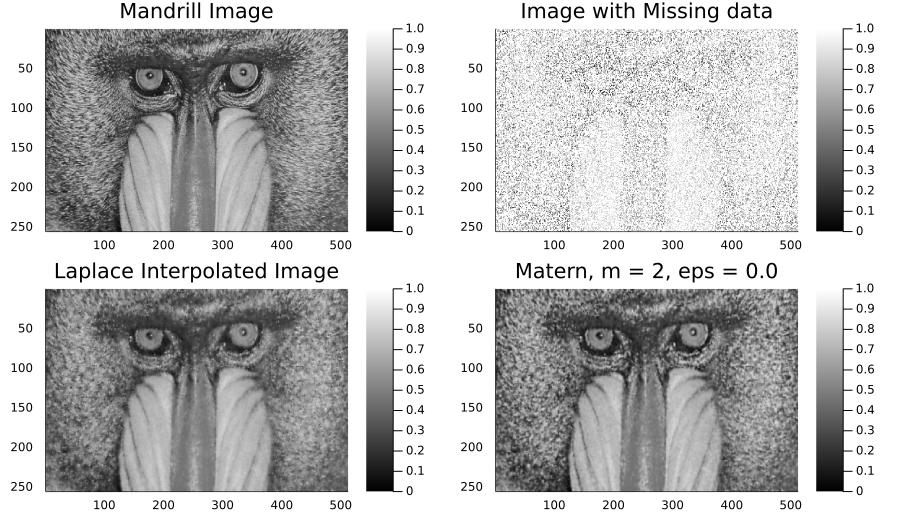

In [13]:

p3 = heatmap(restored_img_laplace, title = "Laplace Interpolated Image", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
p4 = heatmap(restored_img_matern, title = "Matern, m = 2, eps = 0.0", yflip = true, 
              c = :bone, clims = (0.0, 1.0))
plot(p1, p2, p3, p4, layout = (2, 2), legend = false, size = (900, 520))

# png("Mandrill_Random.png")

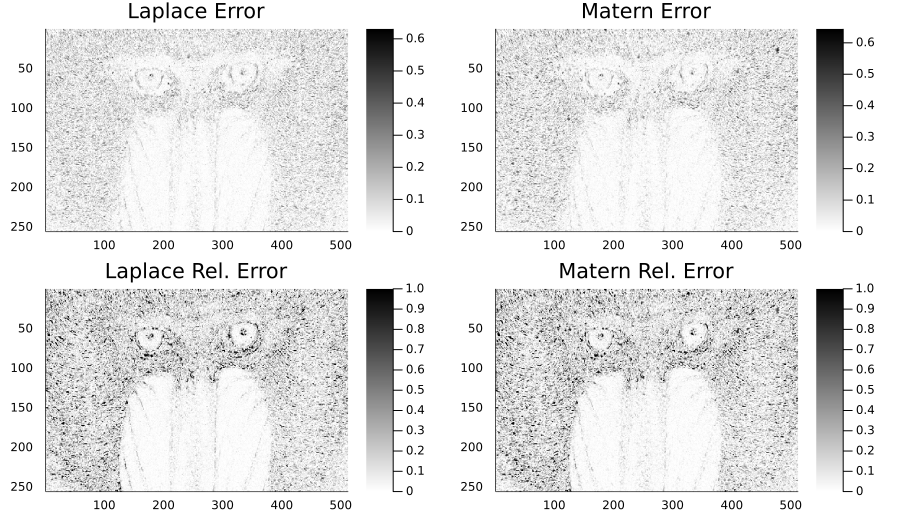

In [21]:
plot1 = heatmap(error_laplace, c = :binary, yflip = true, title = "Laplace Error", pointsize = 15)
plot2 = heatmap(error_matern, c = :binary, yflip = true, title = "Matern Error", pointsize = 15)

plot3 = heatmap(rel_error_lap, yflip = true, title = "Laplace Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))
plot4 = heatmap(rel_error_mat, yflip = true, title = "Matern Rel. Error", pointsize = 15,
                c = :binary, clims = (0.0, 1.0))

plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false, size = (900, 520))
# png("Mandrill_Random_Errors.png")

# Remove islands of data

In [34]:

cent = [(100, 200), (200, 100), (400, 200)]
rad = 20

function punch_holes_2D_pri(centers, radius::Union{T, Vector{T}}, 
                        xpoints, ypoints) where T<:Number
    clen = (typeof(centers) <: Vector) ? length(centers) : 1
    rad  = (typeof(radius) <: Vector) ? radius : radius * ones(clen)
    masking_data_points = []
    absolute_indices = Int64[]
    for a = 1:clen
        c = centers[a]
        count = 1
        for j = 1:ypoints
            for h = 1:xpoints
                if (((h-c[1]))^2 + ((j-c[2]))^2  <= radius[a]^2)
                    append!(masking_data_points,[(h,j)])
                    append!(absolute_indices, count)
                end
                count = count + 1
            end
        end
    end
    return absolute_indices
end

#=
c = cent[1]
rows = 1:size(mat,1)
columns = 1:size(mat,2)

mask = ones(size(mat))
mask = broadcast(+, (rows .- c[1]).^2, (columns .- c[2])'.^2) .> rad^2

keep = collect(1:prod(size(mat)))

fun(c, k) = filter(x -> (floor(x/size(mat,1)) .- c[1]).^2 + (x%size(mat,1) .- c[2])'.^2 > rad^2, k)

keep = fun(cent[1], keep)
keep = fun(cent[2], keep)
keep = fun(cent[3], keep)

prod(size(mask)) - sum(mask[keep]), 2*20^2*pi;
=#

mask = punch_holes_2D_pri([(100, 200), (200,100)], [rad, rad], rows, columns)

2514-element Array{Int64,1}:
 45924
 46174
 46175
 46176
 46177
 46178
 46179
 46180
 46181
 46182
 46183
 46184
 46185
     ⋮
 30404
 30405
 30406
 30407
 30408
 30409
 30410
 30411
 30412
 30413
 30414
 30664

In [24]:
typeof(rows)

Int64

In [ ]:
S = [i*size(mat,2)+j for i in 0:(size(mat,1)-1) for j in 1:size(mat,2)]
vals = mat[:]
holeyimage = ones(size(mat,1),size(mat,2))
holeyimage[S[keep]] = vals[keep]
Plots.plot(Gray.(holeyimage))

In [ ]:
 # if you need
using PyPlot

include("polyharmonic_splines.jl") 
# contain all code from https://github.com/lstagner/PolyharmonicSplines.jl
# and `interpolate()`definition from https://gist.github.com/lstagner/04a05b120e0be7de9915

# x = floor.(keep/(size(mat,1)));
# y = (keep.%(size(mat,1)));
# z = holeyimage[S[keep]];
# S2 = PolyharmonicSpline(2,[x y],z)

# BenchmarkTools.DEFAULT_PARAMETERS.seconds = 1000;
# BenchmarkTools.DEFAULT_PARAMETERS.samples = 50;

function tps_interpolate()
xarray = Float64[]
yarray = Float64[]
zarray = Float64[]
for x in 80:120
    for y in 180:220
        if((x -100)^2 + (y-200)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end

for x in 380:420
    for y in 180:220
        if((x -400)^2 + (y-200)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end

for x in 180:220
    for y in 80:120
        if((x -200)^2 + (y-100)^2 > 20^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, mat[y,x]);
        end
    end
end
S2 = PolyharmonicSpline(2,[xarray yarray],zarray);

x=ones(41)*(80:120)';
xx = reshape(x,41*41);
y = (180:220)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
holeyimage_copy = copy(holeyimage)
count =1;
for i in 80:120
    for j in 180:220
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end

x=ones(41)*(180:220)';
xx = reshape(x,41*41);
y = (80:120)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
# holeyimage_copy = copy(holeyimage)
count =1;
for i in 180:220
    for j in 80:120
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end

x=ones(41)*(380:420)';
xx = reshape(x,41*41);
y = (180:220)*ones(41)';
yy = reshape(y,41*41)
zz = interpolate(S2,xx,yy)
zz_reshape = reshape(zz, 41,41)
# holeyimage_copy = copy(holeyimage)
count =1;
for i in 380:420
    for j in 180:220
        
        holeyimage_copy[j,i] = zz[count]
        count=count+1;
        
    end
end
return holeyimage_copy
end
    

#@btime tps_interpolate()
holeyimage_copy = tps_interpolate()




# xgrid = ones(K)*1:size(mat,1)'
# ygrid = 1:size(mat,2)*ones(L)'

# xx = reshape(xgrid,L*K)
# yy = reshape(ygrid,L*K)

# zz = interpolate(S2,xx,yy)
# zgrid = reshape(zz,n,n);

# plot_surface(xgrid,ygrid,zgrid,alpha=0.5)
# scatter3D(x,y,z,color="r")
# show()




In [ ]:
#@benchmark begin
include("../Matern1D2D.jl")
holeyimage_copy_m = copy(holeyimage);
restored_img1, punched_img = Matern2D(41, 41, mat[80:120,180:220], 0, [(21,21)], 20.0);
count =1;

holeyimage_copy_m[80:120,180:220] = restored_img1;


restored_img, punched_img = Matern2D(41, 41, mat[180:220,80:120], 0, [(21,21)], 20);
holeyimage_copy_m[180:220,80:120] = restored_img;


restored_img, punched_img = Matern2D(41, 41, mat[180:220,380:420], 0, [(21,21)], 20);
holeyimage_copy_m[180:220,380:420] = restored_img;

#end

## Comparison of errors between TPS and Matern Interpolation

In [ ]:
Error_TPS = abs.(mat - holeyimage_copy)
Error_Matern = abs.(mat - holeyimage_copy_m)
plot1 = heatmap(Error_TPS, c= :balance, title="Error in TPS interpolation");
plot2 = heatmap(Error_Matern, c= :balance, title="Error in Matern interpolation");
Plots.plot(plot1, plot2, layout = (1, 2), legend = false)
png("Mandrill_Errors.png")

In [ ]:
ENV["MPLBACKEND"]="tkagg" # if you need

x,y = randn(500),randn(500)
z = exp.(-(x.^2 .+ y.^2))
S2 = PolyharmonicSpline(2,[x y],z)

n=20
xgrid = ones(n)*range(-3,stop=3,length=n)'
ygrid = range(-3,stop=3,length=n)*ones(n)'

xx = reshape(xgrid,n*n)
yy = reshape(ygrid,n*n)

zz = interpolate(S2,xx,yy)
zgrid = reshape(zz,n,n);

plot_surface(xgrid,ygrid,zgrid,alpha=0.5)
scatter3D(x,y,z,color="r")
show()

Take the laplacian matrix and plot it as a heatmap
Implement Dirichlet, Neumann, and Periodic BCs.

In [ ]:

L = 1:300
K = 1:300
xmax = 300
ymax = 300
length_array = length(L)*length(K)
control_indices = 1:15:length_array
number_of_control_points = length(control_indices)
weights = ones(number_of_control_points)
control_values = zeros(number_of_control_points)
xcoordinate = zeros(number_of_control_points)
ycoordinate = zeros(number_of_control_points)
stdx = 50
stdy = 50
mux = 150
muy = 150
for i = 1:number_of_control_points
    xcoor = mod(control_indices[i], xmax)
    ycoor = floor(control_indices[i]/xmax) - 1
    control_values[i] = exp(-((xcoor - mux)/stdx)^2 - ((ycoor - muy)/stdy)^2)
    xcoordinate[i] = xcoor
    ycoordinate[i] = ycoor
end
scatter3D(xcoordinate,ycoordinate,control_values,color="m")


In [ ]:
function evaluate_rbfkernel(r)
    if(r <= 1e-13)
        return 0
    else
        return r*r*log(r)*0.217147241
    end
end

In [ ]:
fvalues = zeros(length_array)
count =1

for i = 1:ymax
    for j = 1:xmax
        xcoor = j-1
        ycoor = i-1
        for k = 1:number_of_control_points
            r = sqrt((xcoordinate[k] - xcoor)^2 +  (ycoordinate[k] - ycoor)^2)
            fvalues[count] = fvalues[count] + weights[k]*evaluate_rbfkernel(r/100)
        end
        count = count+1
    end
end
        

In [ ]:
n=300
xgrid = ones(n)*range(1,stop=300,length=n)'
ygrid = range(1,stop=300,length=n)*ones(n)'
fvalues_mat = reshape(fvalues, xmax, ymax)
plot_surface(xgrid,ygrid,fvalues_mat,alpha=0.5)

In [ ]:
heatmap(fvalues_mat, c= :balance)

In [ ]:
include("../Matern1D2D.jl")
restored_img1, punched_img = Matern2D(300, 300, fvalues_mat[1:300,1:300], 0, [(100,100)], 50);

In [ ]:
heatmap(restored_img1, c=:balance)

In [ ]:
plot1 = heatmap(fvalues_mat, c= :balance, title="RBF Kernel Data", pointsize=15);
plot2 = heatmap(punched_img, c= :balance, title="Data with missing points");
plot3 = heatmap(restored_img1, c= :balance, title="Matern Interpolated Image");
plot4 = heatmap(abs.(restored_img1 - fvalues_mat), c= :balance, title="Error in Mat Interp");
Plots.plot(plot1, plot2, plot3, plot4, layout = (2, 2), legend = false)
png("RBF_Errors_Matern.png")

# Verifying PolyharmonicSpline code

In [ ]:
include("ThinPlateSplines.jl")
include("polyharmonic_splines.jl") 

xarray = Float64[]
yarray = Float64[]
zarray = Float64[]
for x in 1:xmax
    for y in 1:ymax
        if((x -100)^2 + (y-100)^2 > 50^2)
            xarray = append!(xarray, x);
            yarray = append!(yarray, y);
            zarray = append!(zarray, fvalues_mat[y,x]);
        end
    end
end

S2 = PolyharmonicSpline(2,[xarray yarray],zarray);

zz = interpolate(S2,xgrid,ygrid)
zz_reshape = reshape(zz, xmax,ymax)

# 3D Example

In [ ]:
function evaluate_rbfkernel3D(r)
    return r
end

In [ ]:
using PyPlot
L = 1:50
K = 1:50
H = 1:50
length_array = length(L)*length(K)*length(H)
control_indices = 1:15:length_array
number_of_control_points = length(control_indices)
weights = ones(number_of_control_points)
control_values = zeros(number_of_control_points)
xcoordinate = zeros(number_of_control_points)
ycoordinate = zeros(number_of_control_points)
zcoordinate = zeros(number_of_control_points)

stdx = 8
stdy = 8
mux = 25
muy = 25
for i = 1:number_of_control_points
    xcoor = mod(control_indices[i], xmax)
    ycoor = floor(control_indices[i]/xmax) - 1
    control_values[i] = exp(-((xcoor - mux)/stdx)^2 - ((ycoor - muy)/stdy)^2)
    xcoordinate[i] = xcoor
    ycoordinate[i] = ycoor
end
scatter3D(xcoordinate,ycoordinate,control_values,color="m")